# Macroeconomic report in MS Word
* By: Joakim Blix Prestmo
* With help from: Haakon Trønnes
* Last update: 21.11.2019



In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
# import pandas_datareader.data as web

In [87]:
# Basis year in the National Account database
fixedprices = "2017-prices"
# most recent quarter
lastquarter = "2019Q3"


In [51]:
# Data from the National Account, fixed prices, ses adjust and unadjusted
dfses = pd.read_csv('http://data.ssb.no/api/v0/dataset/59022.csv?lang=no', encoding = 'latin1', na_values = '..', sep=";")
# Take out only seasonal adjusted figures:
dfses  = dfses[dfses["statistikkvariabel"]=="Faste 2017-priser, sesongjustert (mill. kr)"]
# Remove column (no need of this now)
dfses.drop('statistikkvariabel',1, inplace=True)
# Convert quarter (kvartal) to an international time format
dfses['kvartal'] =pd.Series(dfses['kvartal']).str.replace('K', 'Q')
pd.to_datetime(dfses['kvartal'])
# Pivot the dataset to the makrostørrelse (macroeconomic variables) in columns
dfses = dfses.pivot(index = 'kvartal', columns = 'makrostørrelse', values = '09190: Makroøkonomiske hovedstørrelser, etter makrostørrelse, kvartal og statistikkvariabel')
#  Make variable names more readable (but not understandable - need a dictionary for that)
dfses.columns = [dfses.columns.str.split(' ')[i][0] for i in range(len(dfses.columns))]
kolonnenavn = list(dfses.columns.values)



In [54]:
# Pickle data so that you don't need to reload data when working/adjusting with figures and tables in this notebook
dfses.to_pickle('Data/df_na.pkl')
# dfses = pd.read_pickle("Data/df_na.pkl")

In [55]:
# Feature engineering
# Log GDP, smoothed GDP, quarterly and yearly growth rates
# Mean growth rates, and smoothed growth rates
# GDP-gap is defined as deviation in growth rates from mean growth rate

dfses['log_BNP'] = np.log(dfses['bnpb.nr23_9fn'])
dfses['Glog_BNP'] = dfses['log_BNP'].rolling(window=7, center=True).mean()
dfses['Dlog_BNP'] = (dfses['log_BNP']).diff()
dfses['D4log_BNP'] = dfses['log_BNP'].diff(4)
dfses['DBNP-trend'] = dfses['Dlog_BNP']['1998K1':lastquarter].mean()
dfses['GDlog_BNP'] = dfses['Dlog_BNP'].rolling(window=7, center=True).mean()
dfses['BNP-gap'] = (dfses['GDlog_BNP']/dfses['DBNP-trend']-1)

# dfses['Glog_BNP'] = dfses['log_BNP'].rolling(window=25).mean()



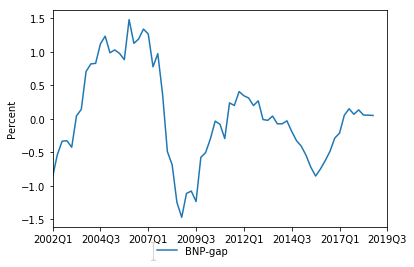

In [92]:
# GDP sesadjusted growth

#dfses['Dlog_BNP']['2008K2':'2017K3'].plot(label = 'Bruttonasjonalprodukt Fastlands-Norge')
#dfses['GDlog_BNP']['2008K2':'2017K3'].plot(label='Trendvekst')
dfses['BNP-gap']['2002Q1':lastquarter].plot(label='BNP-gap')
# plt.title('GDP-gap. Departure from trend growth in percentage points')
plt.ylabel('Percent')
plt.xlabel('')
plt.legend(bbox_to_anchor=(0.3, -0.15), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fancybox=True )
#plt.legend()
plt.savefig('Figures/GDPgap.png' ,bbox_inches = "tight")
plt.show()




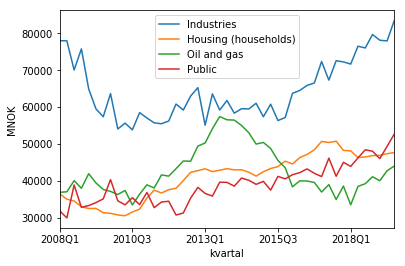

In [89]:
# Real investments
plt.clf()
dfses['bif.nr83naer']['2008K2':lastquarter].plot(label = 'Industries')
dfses['bif.nr8368']['2008K2':lastquarter].plot(label = 'Housing (households)')
dfses['bif.nr83oljroer']['2008K2':lastquarter].plot(label = 'Oil and gas')
dfses['bif.nr84_5']['2008K2':lastquarter].plot(label = 'Public')
# plt.title('Real investments. Fixed '+fixedprices+', seasonal adjusted')
plt.ylabel('MNOK')
plt.legend()
plt.savefig('../Figurer/Makro/RealInvestments.png')

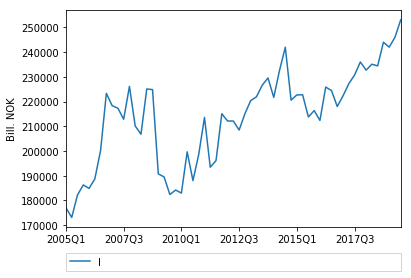

In [90]:
plt.clf()
#1.31 økosirk
#df['bnpb.nr23_9'].plot(label = 'Bruttonasjonalprodukt, markedsverdi')
#df['imp.nrtot'].plot(label = 'Im')#(label = 'Import i alt')
plt.clf()
dfses['bif.nr8_']['2005K3':lastquarter].plot(label = 'I')#(label = 'Bruttoinvestering i alt')
dfses['koh.nrpriv']['2005K3':lastquarter].plot(label = 'C')#(label = 'Konsum i husholdninger og ideelle organisasjoner')
(dfses['eks.nrtot']['2005K3':lastquarter]-dfses['imp.nrtot']['2005K3':lastquarter]).plot(label = 'NX')#(label = 'Eksport i alt')
dfses['makrok.nreoff']['2005K3':lastquarter].plot(label = 'G')#(label = 'Etterspørsel fra offentlig forvaltning')
plt.ylabel('Bill. NOK')
plt.xlabel('')
#plt.legend()
plt.legend(bbox_to_anchor=(0., -0.2, 1, 0.25), loc=4,
           ncol=4, mode="expand", borderaxespad=0., fancybox=False )
# plt.title("Main variables, Fixed "+fixedprices+", seasonal adjusted")
plt.savefig('Figures/EconCirc.png', bbox_inches = "tight")


In [72]:
# macroVars = ['bif.nr8_', 'koh.nrpriv','eks.nrtot', 'makrok.nreoff' ]
macroVarsDic = {'bif.nr8_':'I', 'koh.nrpriv':'C','eks.nrtot':'NX', 'makrok.nreoff':'G'}
macroVars = ['I', 'G', 'NX', 'G']
dfses.rename(columns = macroVarsDic, inplace=True)

# gapminder.rename(columns={'pop':'population',
#                           'lifeExp':'life_exp',
#                           'gdpPercap':'gdp_per_cap'}, 
#                  inplace=True)

In [73]:
# firstquarter = datetime(lastquarter - 4 quarters)...
na_table = dfses[macroVars]['2018Q3':lastquarter]

In [74]:
na_table.to_pickle('Data/na_table.pkl')

## Exchange rates

In [36]:
start= 'StartPeriod=2011'
url = 'https://data.norges-bank.no/api/data/EXR/B.USD+GBP+EUR.NOK.SP?'+start+'&format=csv-:-comma-true-y'

col_names = ['Dato','EURNOK', 'GBPNOK','USDNOK' ]
df = pd.read_csv(url, sep = ',', names=col_names, header=None)

df = df[5:]
# pd.to_numeric(df['EURNOK'], errors='ignore')

pd.to_datetime(df['Dato'])
df.index=df['Dato']
df.drop(['Dato'], axis=1, inplace=True)

# valuta=['GBPNOK','EURNOK','USDNOK']
# df[valuta].astype('float64', copy=True)
df = df.apply(pd.to_numeric, errors='coerce')

df.apply(pd.to_numeric, errors='coerce').dtypes


EURNOK    float64
GBPNOK    float64
USDNOK    float64
dtype: object

In [ ]:
df.to_pickle('Data/df_exch.pkl')

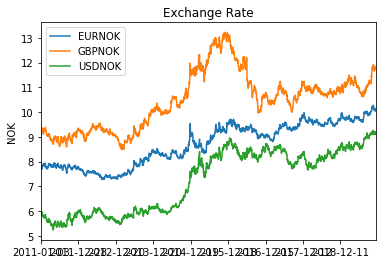

In [37]:
#3 valuta (jeg lager to plot fra denne kategorien for tilpasse størrelsesorden)

df.plot()
plt.xlabel('')
plt.ylabel('NOK')
# plt.title('Exchange Rate')
plt.savefig('Figures/ExchangeRate.png')


In [83]:
# Unemployment rates
plt.clf()
dfaku = pd.read_csv('http://data.ssb.no/api/v0/dataset/1054.csv?lang=en', names = ['sex', 'age','contents', 'time', 'value'], header = 0)

#cleaning
for i in range(len(dfaku['value'])):
    #df['value'][i] = str(df['value'][i]).replace(',', '.') #change decimalpoint from ',' to '.'
    dfaku['value'][i] = str(dfaku['value'][i]).replace('..','NaN') # change '..' to 'NaN'
    if dfaku['value'][i] == '.' or dfaku['value'][i] == '0':# find missing values as replace with 'NaN'
        dfaku['value'][i] = 'NaN'

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

C:\Users\i235jbp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


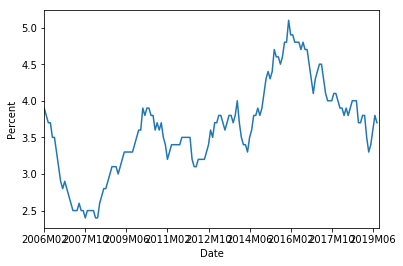

In [84]:
# Unemployment
series = pd.Series(dfaku['value'].astype(np.float64))
series.index = [dfaku[dfaku.columns[i]] for i in range(4)]
l = series.index.levels

series[l[0][0], l[1][1], l[2][14]].plot()
plt.xlabel('Date')
plt.ylabel('Percent')
# plt.title('Unemployment rate for age cohorts within 15-74')
plt.savefig('Figures/Unemployment.png')

In [82]:
dfaku.to_pickle('Data/df_aku.pkl')

In [41]:
# Housing prices 
df = pd.read_csv('http://data.ssb.no/api/v0/dataset/1060.csv?lang=no', encoding = 'latin1', dtype = object, delimiter = ';')
df.columns = ['region', 'boligtype', 'tid', 'statistikkvariabel', 'prisindeks']
#df['Totalt'] = df['TOTAL Hele landet']

for i in range(len(df['tid'])):
    df['tid'][i] = df['tid'][i][:4] + 'Q' + df['tid'][i][5] #change 'K' to 'Q' in for quarter
    df['prisindeks'][i] = str(df['prisindeks'][i]).replace(',', '.') #change decimalpoint from ',' to '.'
    df['prisindeks'][i] = str(df['prisindeks'][i]).replace('..','NaN') # change '..' to 'NaN'
    if df['prisindeks'][i] == '.' or df['prisindeks'][i] == '0':# find missing values as replace with 'NaN'
        df['prisindeks'][i] = 'NaN'


#reorginaze data in a Series with text variables as multilayered indexes
series = pd.Series(df['prisindeks'].astype(np.float64))#, index = [df[df.columns[i]] for i in range(4)])
series.index = [df[df.columns[i]] for i in range(4)]

In [85]:
df.to_pickle('Data/df_house.pkl')

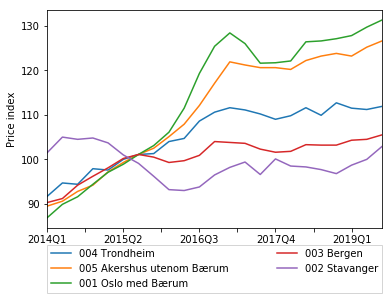

In [76]:
# Housing prices - regions
plt.clf()

liste = ['004 Trondheim', '005 Akershus utenom Bærum', '001 Oslo med Bærum', '003 Bergen', '002 Stavanger']

for i in liste:
    series[i, '00 Boliger i alt', :, 'Prisindeks for brukte boliger, sesongjustert']['2014Q1':].plot(label = i)    
        
#plt.legend()
plt.legend(bbox_to_anchor=(0., -0.3, 1.0, 0.25), loc=4,
           ncol=2, mode="expand", borderaxespad=0., fancybox=False )    
plt.xlabel("")
plt.ylabel('Price index')
# plt.title('Housing prices for largest regions')
plt.savefig('Figures/HousingPrices.png', bbox_inches = "tight" )
plt.show()